In [1]:
from skimage.io import imread_collection
import numpy as np
import matplotlib.pyplot as plt
import pywt as ptw
from math import floor
from sklearn.utils import shuffle
from sklearn import tree
import time
from random import randint
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
def draw(image):
    plt.imshow(image)
    plt.show()
    return

def hwavelet(images, n):
    cA = images
    for i in range(n):
        cA, (cH, cV, cD) = ptw.dwt2(cA, 'haar')
    return cA

def normalizar(dataset):
    aux = []
    for i in range(len(dataset)):
        aux = aux + [dataset[i].reshape(24*24).tolist()]
    return aux


In [3]:
# paths
pathAnger = 'images/anger/*.png'
pathContempt = 'images/contempt/*.png'
pathDisgust = 'images/disgust/*.png'
pathFear = 'images/fear/*.png'
pathHappy = 'images/happy/*.png'
pathSadness = 'images/sadness/*.png'
pathSurprise = 'images/surprise/*.png'

#images
imagesAnger = imread_collection(pathAnger)
imagesContempt = imread_collection(pathContempt)
imagesDisgust = imread_collection(pathDisgust)
imagesFear = imread_collection(pathFear)
imagesHappy = imread_collection(pathHappy)
imagesSadness = imread_collection(pathSadness)
imagesSurprise = imread_collection(pathSurprise)

# Haar Wavelet
imagesAngerHW = hwavelet(imagesAnger,1)
imagesContemptHW = hwavelet(imagesContempt,1)
imagesDisgustHW = hwavelet(imagesDisgust,1)
imagesFearHW = hwavelet(imagesFear,1)
imagesHappyHW = hwavelet(imagesHappy,1)
imagesSadnessHW = hwavelet(imagesSadness,1)
imagesSurpriseHW = hwavelet(imagesSurprise,1)

# Normalizacion
anger = normalizar(imagesAngerHW)
contempt = normalizar(imagesContemptHW)
disgust = normalizar(imagesDisgustHW)
fear = normalizar(imagesFearHW)
happy = normalizar(imagesHappyHW)
sadness = normalizar(imagesSadnessHW)
surprise = normalizar(imagesSurpriseHW)

In [4]:
x = [] # Input
y = [] # Output

x = anger + contempt + disgust + fear + happy + sadness + surprise
y = ['ANGER']*len(anger) + ['CONTEMPT']*len(contempt) + ['DISGUST']*len(disgust) \
    + ['FEAR']*len(fear) + ['HAPPY']*len(happy) + ['SADNESS']*len(sadness) \
    + ['SURPRISE']*len(surprise)

# Shuffle data
x, y = shuffle(x, y, random_state = 0)

In [5]:
def bootstrap(x, y, k = 10):
    N = len(x)
    result = []
    error = 0
    errores = []
    varianza = 0
    p = 8

    i = 0
    
    while i < k:
        x_testing = []
        y_testing = []
        x_training = []
        y_training = []
        y_prediction = []
        indices = [0] * N # Para saber cuales estan en el training y no ponerlos en el testing
        
        # Escoger los N para el training
        while len(x_training) < N:
            for idx, punto in enumerate(x):
                if len(x_training) >= N:
                    break
                value = randint(0, 10)
                if value <= p: # p% de posibilidades
                    x_training.append(punto)
                    y_training.append(y[idx])
                    indices[idx] = 1

        # Escoger el resto para el testing
        for idx, punto in enumerate(x):
            if indices[idx] == 0:
                x_testing.append(punto)
                y_testing.append(y[idx])

        # El testing esta vacio, repetir experimento
        if len(x_testing) == 0:
            continue

        # Crear modelo
        modelo = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
        modelo = modelo.fit(x_training, y_training)

        # Testing
        buenas = 0
        malas = 0
        for idx, punto in enumerate(x_testing):
            prediccion = modelo.predict([punto])
            y_prediction.append(prediccion)
            if prediccion == y_testing[idx]:
                buenas += 1
            else:
                malas += 1
        matrix = confusion_matrix(y_testing, y_prediction, labels=["ANGER", "CONTEMPT", "DISGUST", "FEAR", "HAPPY", "SADNESS", "SURPRISE"])
        result.append([modelo, x_testing, y_testing])

        # Error (1 - (buenas/total))
        error_i = 1 - (sum([matrix[indice][indice] for indice in range(len(matrix))]) / np.sum(matrix))
        error += error_i
        errores.append(error_i)

        i += 1
    # Varianza
    error_promedio = error/k
    for error_i in errores:
        varianza += (error_i - error_promedio)**2
    varianza /= (k - 1)
    print('El error es de:', error_promedio)
    print('La varianza es de:', varianza)
    return result

In [6]:
def k_folds(x, y, k = 10):
    # indices para el testing
    inicio = 0
    fin = 0
    block = len(x) / k
    error = 0
    errores = []
    varianza = 0

    # Resultado por cada grupo (buenas y malas)
    result = []

    for i in range(k):
        # Limites del bloque de test
        inicio = block * i
        fin = block * (i + 1)

        x_testing = []
        y_testing = []
        x_training = []
        y_training = []
        y_prediction = []

        # Separar los bloques
        for idx, punto in enumerate(x):
            if idx < inicio or idx > fin:
                x_training.append(punto)
                y_training.append(y[idx])
            else:
                x_testing.append(punto)
                y_testing.append(y[idx])

        # Crear modelo
        modelo = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
        modelo = modelo.fit(x_training, y_training)
        # tree.plot_tree(modelo)

        # Testing
        buenas = 0
        malas = 0
        for idx, punto in enumerate(x_testing):
            prediccion = modelo.predict([punto])
            y_prediction.append(prediccion)
            if prediccion == y_testing[idx]:
                buenas += 1
            else:
                malas += 1
        matrix = confusion_matrix(y_testing, y_prediction, labels=["ANGER", "CONTEMPT", "DISGUST", "FEAR", "HAPPY", "SADNESS", "SURPRISE"])
        result.append([modelo, x_testing, y_testing])

        # Error (1 - (buenas/total))
        error_i = 1 - (sum([matrix[indice][indice] for indice in range(len(matrix))]) / np.sum(matrix))
        error += error_i
        errores.append(error_i)
    
    # Varianza
    error_promedio = error/k
    for error_i in errores:
        varianza += (error_i - error_promedio)**2
    varianza /= (k - 1)

    print('El error es de:', error_promedio)
    print('La varianza es de:', varianza)
    return result

El error es de: 0.12441764584621728
La varianza es de: 0.0010914416802746158
Tiempo total de testing con k-folds (k = 10) 5.601999998092651 segundos.


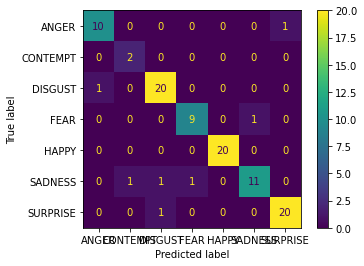

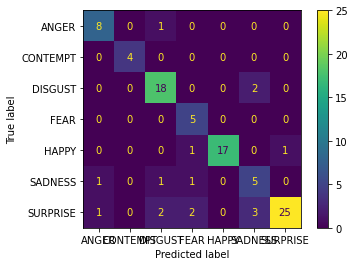

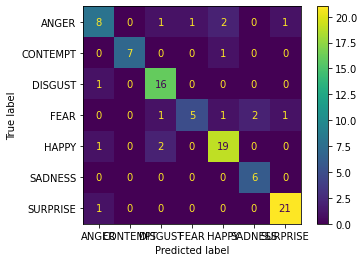

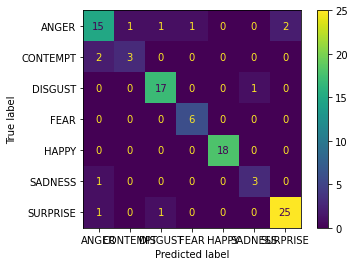

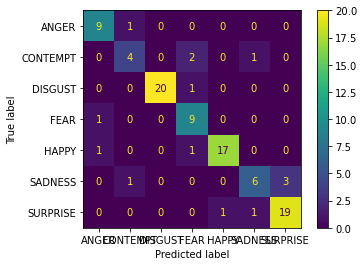

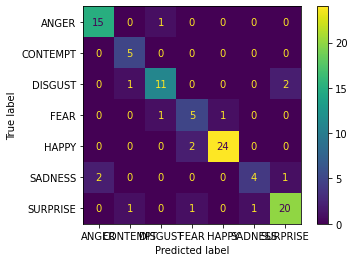

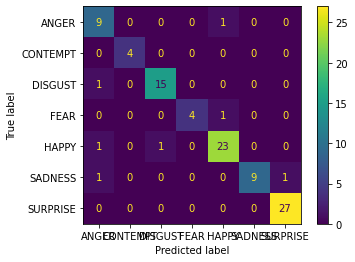

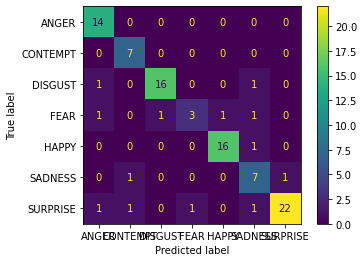

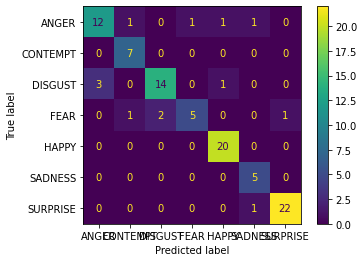

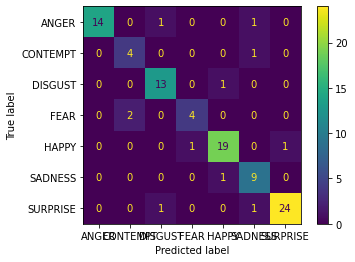

In [7]:
k = 10

start = time.time()
result_k_folds = k_folds(x, y, k)
end = time.time()
print('Tiempo total de testing con', 'k-folds (k = ' + str(k) + ')', end-start, 'segundos.')

# Matrices de confusion
for result in result_k_folds:
    plot_confusion_matrix(result[0], result[1], result[2])  
    plt.show() 

El error es de: 0.15204052144755809
La varianza es de: 0.0005526750666568665
Tiempo total de testing con bootstrap (10 experimentos) 5.428025245666504 segundos.


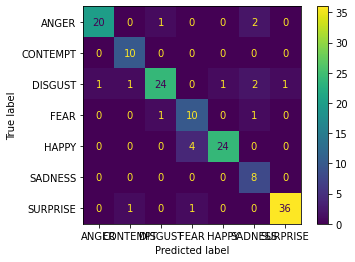

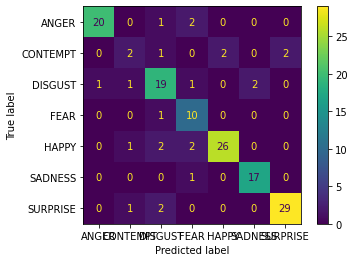

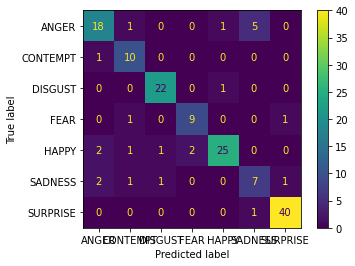

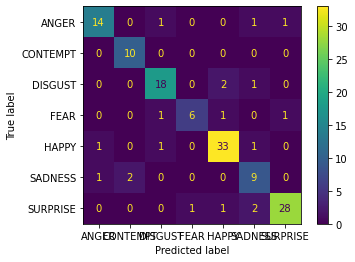

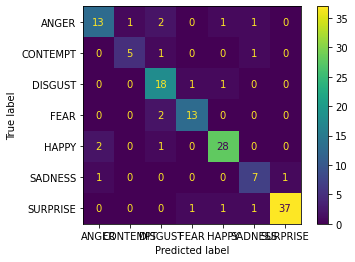

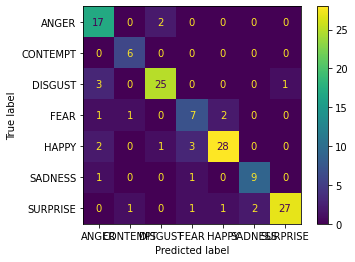

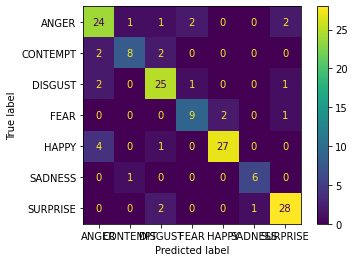

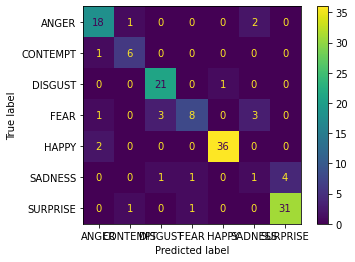

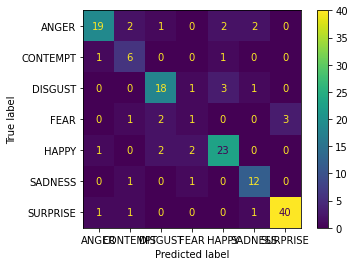

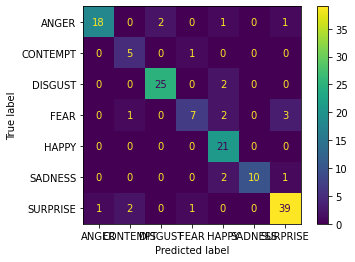

In [8]:
k = 10

start = time.time()
result_bootstrap = bootstrap(x, y, k)
end = time.time()
print('Tiempo total de testing con bootstrap (' + str(k) + ' experimentos)', end-start, 'segundos.')

# Matrices de confusion
for result in result_bootstrap:
    plot_confusion_matrix(result[0], result[1], result[2])  
    plt.show() 